In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os 
from scipy.stats import binom_test
from sequencing_tools.stats_tools import p_adjust
from scipy.stats import beta
from scipy.special import betaln
from functools import partial
from repeats_utils import *
from plotting_utils import spring_layout
from math import log
from plotting_utils import figure_path
#import adjustText
plt.rc('axes', labelsize=15)
plt.rc('xtick', labelsize = 15)
plt.rc('ytick', labelsize = 15)

In [7]:
count_table = '/stor/work/Lambowitz/cdw2854/cfNA/tgirt_map/Counts/all_counts/spreaded_all_counts.tsv'
df = pd.read_table(count_table)
df.head()

,gene_id,gene_name,gene_type,grouped_type,IGG-cf_R1_001:all:antisense,IGG-cf_R1_001:all:sense,IGG-cf_R1_001:dedup:antisense,IGG-cf_R1_001:dedup:sense,QCF1_R1_001:all:antisense,QCF1_R1_001:all:sense,...,S96-cfD_R1_001:dedup:antisense,S96-cfD_R1_001:dedup:sense,S96-cf_R1_001:all:antisense,S96-cf_R1_001:all:sense,S96-cf_R1_001:dedup:antisense,S96-cf_R1_001:dedup:sense,genome-sim_R1_001:all:antisense,genome-sim_R1_001:all:sense,genome-sim_R1_001:dedup:antisense,genome-sim_R1_001:dedup:sense
0,.,.,No features,No features,11158,11158,9276,9276,14292,14292,...,34136,34136,70777,70777,48658,48658,12346610,12346610,12340582,12340582
1,18S_rRNA,18S_rRNA,18S_rRNA,rRNA,889,780,583,491,565,155915,...,650,54222,1684,105674,1138,56461,211,236,211,233
2,28S_rRNA,28S_rRNA,28S_rRNA,rRNA,1172,1527,741,990,854,345567,...,1248,144037,2675,284094,1772,149656,475,510,454,461
3,5.8S_rRNA,5.8S_rRNA,5.8S_rRNA,rRNA,0,422,0,173,53,166389,...,45,91810,90,382151,48,94217,21,20,21,20
4,5S_rRNA,5S_rRNA,5S_rRNA,rRNA,0,8,0,5,111,225224,...,3,1362,3,2633,3,1403,1260,1182,477,231


(4.5513505600885775, 4.5304052660888505, 0, 1)


/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


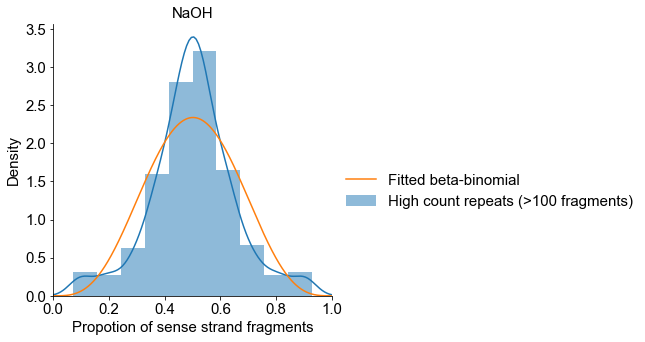

In [8]:
fig = plt.figure(figsize=(5,5))
#ax = fig.add_subplot(121)
sample_regex = 'Q[cC][fF][0-9]+'
#sample_regex = '[aA][lL][lL]'
p_df = get_repeat_df(df, sample_regex = sample_regex)


ax = fig.add_subplot(111)
sample_regex = 'Q[cC][fF]_[Nn][aA]'
naoh_p_df = get_repeat_df(df, sample_regex = sample_regex)
naoh_alpha0, naoh_beta0 = model_df(naoh_p_df, ax, title= 'NaOH')
ax.legend(bbox_to_anchor = (1,0.5), fontsize=15, frameon=False)

Text(22.125, 0.5, 'Posterior sense strand proportion')

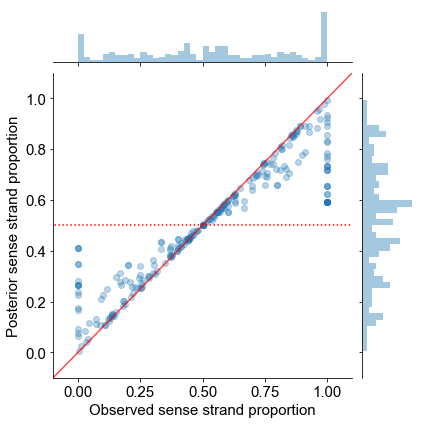

In [9]:
dnase_posterior_df = update_empirical_bayesr(p_df, naoh_alpha0, naoh_beta0)
naoh_posterior_df = update_empirical_bayesr(naoh_p_df, naoh_alpha0, naoh_beta0)

p = sns.JointGrid(data = dnase_posterior_df,  x= 'average',y='eb_estimate')
p.plot_joint(plt.scatter, alpha=0.3)
p.plot_marginals(sns.distplot, kde=False, bins=40)
ax = p.ax_joint
ax.hlines(xmin=-10,xmax=10, 
          y=naoh_alpha0/(naoh_alpha0+naoh_beta0), color='r', linestyle=':')
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),
    np.max([ax.get_xlim(), ax.get_ylim()])
]
ax.plot(lims, lims, 'r-', alpha=.7)
ax.set_xlim(-0.1,1.1)
ax.set_ylim(-0.1,1.1)
ax.set_xlabel('Observed sense strand proportion')
ax.set_ylabel('Posterior sense strand proportion')
#sns.despine()

In [10]:
posterior_df = pd.concat([dnase_posterior_df.assign(treatment = 'DNase'),
         naoh_posterior_df.assign(treatment='NaOH')]) \
    .pipe(pd.melt, id_vars = ['treatment','gene_name','gene_id']) \
    .assign(variable = lambda d: d.treatment + ': ' + d.variable) \
    .pipe(pd.pivot_table, index=['gene_name', 'gene_id'],
         columns = 'variable', values = 'value') \
    .pipe(lambda d: fill_prior(d, (naoh_alpha0, naoh_beta0)))\
    .reset_index() \
    .fillna(0)\
    .pipe(lambda d: calulate_probability(d))  \
    .assign(delta_sense = lambda d: d['DNase: eb_estimate'] - d['NaOH: eb_estimate'])
posterior_df.sort_values('log_bf', ascending=False).head(20)
posterior_df.head()

variable,gene_name,gene_id,DNase: alpha1,DNase: antisense,DNase: average,DNase: beta1,DNase: eb_estimate,DNase: sense,NaOH: alpha1,NaOH: antisense,NaOH: average,NaOH: beta1,NaOH: eb_estimate,NaOH: sense,log_bf,pval,qval,delta_sense
274,Simple_repeats:(TCCG)n,Simple_repeats,1696.551351,4.0,0.997642,8.530405,0.994997,1692.0,259.551351,149.0,0.631188,153.530405,0.628329,255.0,287.829450,0.0,0.0,0.366668
1,Satellite:(GAATG)n,Satellite,18726.551351,6521.0,0.741671,6525.530405,0.741584,18722.0,209501.551351,299036.0,0.411963,299040.530405,0.411965,209497.0,19798.583621,0.0,0.0,0.329619
222,Simple_repeats:(GAGTG)n,Simple_repeats,4551.551351,649.0,0.875096,653.530405,0.874444,4547.0,24351.551351,28369.0,0.461852,28373.530405,0.461859,24347.0,3755.061565,0.0,0.0,0.412585
173,Simple_repeats:(CGG)n,Simple_repeats,5577.551351,677.0,0.891680,681.530405,0.891113,5573.0,1111.551351,1820.0,0.378203,1824.530405,0.378583,1107.0,3431.699206,0.0,0.0,0.512530
219,Simple_repeats:(GAATG)n,Simple_repeats,3717.551351,626.0,0.855727,630.530405,0.854987,3713.0,22542.551351,25284.0,0.471289,25288.530405,0.471295,22538.0,3085.362665,0.0,0.0,0.383691


In [ ]:
p = sns.FacetGrid(data =pd.concat([dnase_posterior_df.assign(treatment = 'DNase'),
                            naoh_posterior_df.assign(treatment='NaOH')])\
                      .assign(eb_estimate = lambda d: d.eb_estimate * 100), 
              hue = 'treatment',
              size = 4)
p.map(sns.distplot, 'eb_estimate')
p.set_axis_labels('Posterior sense strand %',
                'Density')
p.add_legend(title='', fontsize=15)

In [3]:
#https://repository.upenn.edu/cgi/viewcontent.cgi?article=3272&context=edissertations
telo = 'TAACCC|CCCGAA|CCCCAA|CCCTAG|TTAGGC|TTAGGG'
telo += '|' + reverse_complement(telo)
x_val = 'delta_sense'
y_val = 'log_bf'
plot_bf_df = posterior_df\
    .query('log_bf  > 0') \
    .assign(label = lambda d: np.where(d[x_val] < 0, 'Antisense','Sense')) \
    .assign(color = lambda d: 'gray')\
    .assign(color = lambda d: np.where(d.log_bf > 500, 'red', 
                                       np.where(d.log_bf > 2, 'darkred', d.color)))\
    .sort_values('log_bf', ascending=False)
plot_bf_df.head()

NameError: name 'posterior_df' is not defined

NameError: name 'plot_bf_df' is not defined

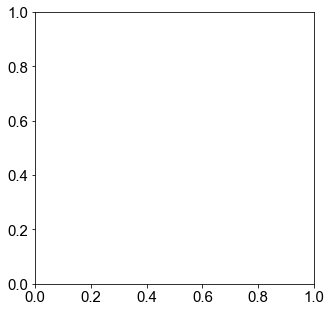

In [4]:
fig = plt.figure(figsize=(5,5))

ax = fig.add_subplot(111)
for lab, lab_df in  plot_bf_df.groupby('label'):
    alpha = 0.8
    color = 'gray' 
        
    data = []
    text = []
    colors = []
    for i, row in lab_df.iterrows():
        x = row[x_val]
        y = row[y_val]
        if (row[y_val] > 2000 or (row[y_val] > 0 and re.search(telo, row['gene_name']))): 
            color = row['color'] if not re.search(telo, row['gene_name']) else 'purple'
            text.append(row['gene_name'])
                
            ax.annotate(row['gene_name'].split(':')[1],
                    xy=(x, y), 
                    xycoords='data',
                    xytext=(x+0.05, y+1), 
                    textcoords='data',
                    color = color,
                    arrowprops=dict(arrowstyle="->",
                            color = color,
                            connectionstyle="arc3"))
    
    lab_df.plot.scatter(x_val, y_val, ax = ax, color = lab_df.color.tolist())#, alpha=alpha )
plt.axvline(x = 0, linestyle=':', alpha=0.01, color='gray')
sns.despine()
#ax.set_ylim(0,1000)
ax.set_ylabel('log(Bayes factor)')
ax.set_xlabel('$\Delta$Sense |DNase - NaOH|')
fig.savefig(figure_path + '/bayes_factor_satellite.png',bbox_inches ='tight')

In [ ]:
plot_bf_df[plot_bf_df.gene_name.str.contains(telo+'|telo')]

In [5]:
posterior_df['total'] =  posterior_df['DNase: antisense'] + posterior_df['DNase: sense']
posterior_df['x'] = posterior_df['DNase: eb_estimate'] * 100
posterior_df['y'] = posterior_df['NaOH: eb_estimate'] * 100

ax = plt.subplot(111)
for i, row in posterior_df.iterrows():
    if  ( row['y']/row['x'] > 2 and row['y'] > 50) or \
            (re.search(telo, row['gene_name']) and row['DNase: eb_estimate'] > row['NaOH: eb_estimate']):
        color = 'purple' if re.search(telo, row['gene_name']) else 'red'
        ax.text(row['x'],row['y'],
               row['gene_name'].replace('Simple_repeats:',''), 
                color=color,ha='left')
    else:
        color = 'grey'
        
    ax.scatter(row['x'], row['y'] , color = color, alpha=0.5)
ax.plot([0,100],[0,100], color = 'orange')
ax.set_ylabel('Posterior DNase sense strand mapping (%)')
ax.set_xlabel('Posterior NaOH sense strand mapping (%)')
ax.set_xlim(0,posterior_df['x'].max() * 1.1)
ax.set_ylim(0,posterior_df['y'].max() * 1.1)
#ax.set_xlim(0,1)
#ax.set_ylim(0,1)
sns.despine()

NameError: name 'posterior_df' is not defined

In [12]:
posterior_df.head()

variable,gene_name,gene_id,DNase: alpha1,DNase: antisense,DNase: average,DNase: beta1,DNase: eb_estimate,DNase: sense,NaOH: alpha1,NaOH: antisense,NaOH: average,NaOH: beta1,NaOH: eb_estimate,NaOH: sense,log_bf,pval,qval,delta_sense
274,Simple_repeats:(TCCG)n,Simple_repeats,1696.551351,4.0,0.997642,8.530405,0.994997,1692.0,259.551351,149.0,0.631188,153.530405,0.628329,255.0,287.829450,0.0,0.0,0.366668
1,Satellite:(GAATG)n,Satellite,18726.551351,6521.0,0.741671,6525.530405,0.741584,18722.0,209501.551351,299036.0,0.411963,299040.530405,0.411965,209497.0,19798.583621,0.0,0.0,0.329619
222,Simple_repeats:(GAGTG)n,Simple_repeats,4551.551351,649.0,0.875096,653.530405,0.874444,4547.0,24351.551351,28369.0,0.461852,28373.530405,0.461859,24347.0,3755.061565,0.0,0.0,0.412585
173,Simple_repeats:(CGG)n,Simple_repeats,5577.551351,677.0,0.891680,681.530405,0.891113,5573.0,1111.551351,1820.0,0.378203,1824.530405,0.378583,1107.0,3431.699206,0.0,0.0,0.512530
219,Simple_repeats:(GAATG)n,Simple_repeats,3717.551351,626.0,0.855727,630.530405,0.854987,3713.0,22542.551351,25284.0,0.471289,25288.530405,0.471295,22538.0,3085.362665,0.0,0.0,0.383691


In [38]:
import pymc3 as pm

def subtract(x,y):
    return x - y

with pm.Model() as model:
    n = 1000
    dnase = pm.BetaBinomial('dnase', alpha =1696.551351, beta = 8.5, n = n)
    naoh = pm.BetaBinomial('naoh', alpha = 259.55, beta = 153.53, n = n)
    
    diff = pm.Deterministic('delta', subtract(dnase, naoh))
    step = pm.Metropolis()
    trace = pm.sample(18000, step=step)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [naoh]
>Metropolis: [dnase]
Sampling 4 chains: 100%|██████████| 74000/74000 [00:20<00:00, 3660.11draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


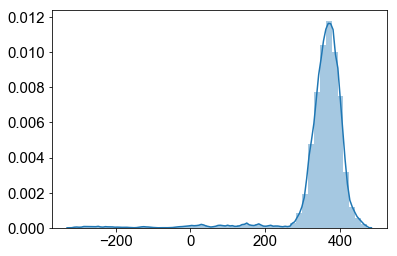

In [39]:
sns.distplot(trace['delta'])

In [ ]:
trace['delta']